# Example Sampling Methods

Based on problems from Chapter 13-14 of Ben Lambert's "[A Student's Guide to Bayesian Statistics](https://study.sagepub.com/lambert)".

In [64]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import beta, binomial, gamma
import scipy.stats as ss

from gibbs_param import Parameter
from gibbs_methods import GibbsSampler

## Gibbs Sampling

### 14.1 - Disease Testing

The test for a particular tropical disease is known to be imperfect, not always identifying the disease if the patient has it, and sometimes yielding false 
positives (patients that do not have the disease but test positive). 

However, by using this test in a clinical trial it is hoped that we can obtain better estimates for the test sensitivity ($S$, the proportion of disease-positive individuals who test positive) and specificity ($C$, the proportion of disease-negative individuals who test negative) [[Joseph1995]](https://pubmed.ncbi.nlm.nih.gov/7840100/).


To do this we can construct a table of the observed and latent data for the test outcomes (see below). In the table $a$ and $b$ are the number of observed positive and negative results, respectively. $Y_{1}$ and $Y_{2}$ are latent variables that represent the gold standard – the true number of positive
individuals out of $a$ and $b$, respectively.


|   | True +     | True - | Sum |
| ----------- | ----------- | ----------- | ----------- |
| **Test +**    | $Y_{1}$      | $ a - Y_{1}$  | $a$ |
| **Test -**  | $Y_{2}$       | $b - Y_{2}$  |  $b$  |
| **Sum**  | $Y_{1} + Y_{2}$       | $N - (Y_{1} +Y_{2})$  |  $N$  |

#### Likelihood

Assuming the prevalence of the disease is $\pi$, we may write the likelihood as:

$$
L(a,b| Y_{1}, Y_{2}, \pi, S, C) = [\pi S]^{Y_{1}} \times [(1 - \pi)(1 - C)]^{a - Y_{1}} \times [\pi(1 - S)]^{Y_{2}} \times [(1 - \pi)C]^{b - Y_{2}}
$$

(The first term $[\pi S]^{Y_{1}}$ is the proportion of individuals with the disease ($\pi$) times the test specificity ($S$), giving the probability that we correctly identify one person as having the disease. This is raised to the power $Y_{1}$ since there are this many individuals with the disease in our sample.)



#### Priors

Let us assume priors of the form:

* $\pi ∼ beta(\alpha_{\pi} , \beta_{\pi})$
* $S ∼ beta(\alpha_{S} , \beta_{S})$
* $C ∼ beta(\alpha_{C} , \beta_{C})$

Using these, the Gibbs sampler is of the form:

* $Y_{1}|a, \pi, S, C \sim binomial\left(a, \frac{\pi S}{\pi S + (1-\pi)(1-C)} \right)$
* $Y_{2}|b, \pi, S, C \sim binomial\left(b, \frac{\pi (1 -S)}{\pi (1-S) + (1-\pi)C} \right)$
* $\pi |a,b,Y_{1},Y_{2} \sim beta(Y_{1} + Y_{2} + \alpha_{\pi}, a+b-Y_{1}-Y_{2}+\beta_{\pi})$
* $ S|Y_{1}, Y_{2} \sim beta(Y_{1} + \alpha_{S}, Y_{2} +\beta_{S})$
* $ C|a,b,Y_{1}, Y_{2} \sim beta(b-Y_{2} + \alpha_{C},a-Y_{1} +\beta_{C})$

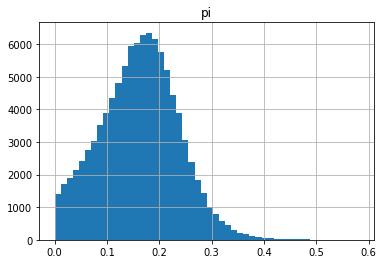

In [2]:
prior_params = {'alpha_pi': 1, 'beta_pi': 1,  # Uniform prior for beta dist
                'alpha_S': 10, 'beta_S': 1,  # Informed prior from previous study
                'alpha_C': 10, 'beta_C': 1}

# Sample initial values from the priors
priors = {'pi': beta(prior_params['alpha_pi'], prior_params['beta_pi']),
          'S': beta(prior_params['alpha_S'], prior_params['beta_S']),
          'C': beta(prior_params['alpha_C'], prior_params['beta_C'])}
sample = {'a': 20, 'b':  80}  # From sample dataset

params = {
    'Y1': Parameter(sample['a'], binomial, lambda a, pi, S, C, **kwargs: {'n':a, 'p':(pi*S)/((pi*S)+(1-pi)*(1-C))}),
    'Y2': Parameter(sample['b'], binomial, lambda b, pi, S, C, **kwargs: {'n':b, 'p':(pi*(1-S))/((pi*(1-S))+(1-pi)*C)}),
    'pi': Parameter(priors['pi'], beta, lambda a, b, Y1, Y2, **kwargs: {'a':Y1+Y2+prior_params['alpha_pi'], 'b': a+b-Y1-Y2+prior_params['beta_pi']}),
    'S': Parameter(priors['S'], beta, lambda Y1, Y2, **kwargs: {'a':Y1+prior_params['alpha_S'], 'b': Y2+prior_params['beta_S']}),
    'C': Parameter(priors['C'], beta, lambda a, b, Y1, Y2, **kwargs: {'a':b-Y2+prior_params['alpha_C'], 'b': a-Y1+prior_params['beta_C']})
}

gibbs = GibbsSampler(params = {**params, **prior_params, **sample})
output = gibbs.sampling_routine(100000)
output.hist('pi', bins=50);

### 14.2 - Mining Disasters

We consider time series of the annual number of coal mining disasters in the UK from 1851 to 1961 [5], using Gibbs sampling to estimate the point in time when legislative and societal changes caused a reduction in coal mining disasters.

#### Model

We will model the number of disasters $D_{t}$ in a given year $t$ by:

$$
D_{t} \sim Poisson(\lambda(t))
$$

where $\lambda(t) = \lambda_{1}$ for $t \leq n$, and $\lambda(t) = \lambda_{2}$ for $t > n$.

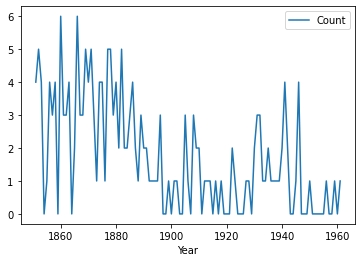

In [3]:
# Data trends

mine_df = pd.read_csv("../../data/other/gibbs_coal.csv")
mine_df.plot('Year', 'Count');
# Clear change in disaster rate between 1880 - 1900.

#### Priors

Let us assume the same $\lambda_{i} \sim \Gamma(a,b)$ priors for $i = {1,2}$, and a discrete uniform prior for $n$ between 1851 and 1961.

The full (un-normalised) posterior density $P(\lambda_{i}|x_{t}) = P(x_{t}|\lambda_{i})P(\lambda_{i})$ is therefore given in full by:

$$
P(\lambda_{1},\lambda_{2},n|x_{1:N},a,b) \propto p(x_{1:n}|\lambda_{1})p(x_{n+1:N}|\lambda_{2})p(\lambda_{1}|a,b)p(\lambda_{2}|a,b)p(n)
$$

This probability for unknowns (rates $\lambda_{i}$ and changepoint $n$) is conditional upon the known prior parameters ($a, b$, as well as the data $x_{1:N}$). We can calculate this explicitly:

$$
p(x_{1:n}|\lambda_{1})p(x_{n+1:N}|\lambda_{2})p(\lambda_{1}|a,b)p(\lambda_{2}|a,b)p(n)
 = Poisson(x_{1:n}|\lambda_{1}) Poisson(x_{n+1:N}|\lambda_{2}) \times \Gamma(\lambda_{1}|a,b) \Gamma(\lambda_{2}|a,b) p(n)
$$

#### Conditional Distribution

##### Rate Constants
We may determine the conditional distribution for $\lambda_{1}$ ($p(\lambda_{1}|x_{1:n},a,b)$) by finding all those terms in the density that include $\lambda_{1}$, and removing the rest as constants of proportionality. Therefore:

$$
p(\lambda_{1}|x_{1:n},a,b) \propto Poisson(x_{1:n}|\lambda_{1}) \times \Gamma(\lambda_{1}|a,b)
$$

However, as the gamma distribution ia the conjugate prior to the Poisson likelihood, we can obtain:

$$
p(\lambda_{1}|x_{1:n},a,b) \sim \Gamma \left(a + \sum_{t=1}^{n}x_{t}, b+n \right)
$$

Similarly for $\lambda_{2}$:

$$
p(\lambda_{2}|x_{n+1:N},a,b) \sim \Gamma \left(a + \sum_{t=n+1}^{N}x_{t}, b+N-n \right)
$$

##### Changepoint

We may write the conditional distribution for $n$ as:

$$
p(n|x_{1:N},\lambda_{1},\lambda_{2}) \propto Poisson(x_{1:n}|\lambda_{1}) Poisson(x_{n+1:N}|\lambda_{2}) p(n)
$$

Assuming a uniform prior for $n$ (equal to $1/N$), and writing each term explicitly:

$$
p(n|x_{1:N},\lambda_{1},\lambda_{2}) \propto \left(\prod_{t=1}^{n}\frac{\lambda_{1}^{x_{t}}e^{-\lambda_{1}}}{x_{t}!} \right) \times \left(\prod_{t=n+1}^{N}\frac{\lambda_{2}^{x_{t}}e^{-\lambda_{2}}}{x_{t}!} \right) 
$$

from which we can drop the constant terms to obtain:

$$
p(n|x_{1:N},\lambda_{1},\lambda_{2}) \propto \lambda_{1}^{\sum_{t=1}^{n}x_{t}}e^{-n\lambda_{1}}  \times \lambda_{2}^{\sum_{t=n+1}^{N}x_{t}}e^{-(N-n)\lambda_{2}}
$$



In [4]:
def unnormalised_posterior_n(n, x, lambda_1, lambda_2):
    """Unnormalised conditional distribution for changepoint n, conditional on
    the data x and the rates (before/after) lambda_1 and lambda_2."""
    if n == len(x):
        return 0  # Change cannot occur at final point
    term_1 = lambda_1**(sum(x[:int(n+1)])) * np.exp(-n * lambda_1)
    term_2 = lambda_2**(sum(x[int(n+1):])) * np.exp(-(len(x) - n) * lambda_2)
    return term_1 * term_2

Peak probability for changepoint occurs in 1890.


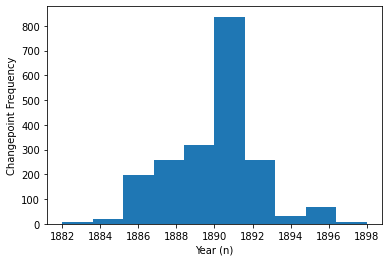

In [5]:
def sample_conditional_n(x, lambda_1, lambda_2, **kwargs):
    """Returns sample from consitional posterior distriubtion for
    n, conditional on the data x and the rates (before/after) 
    lambda_1 and lambda_2."""
    n_prob = [unnormalised_posterior_n(n, x, lambda_1, lambda_2) for n in range(len(x))]
    return random.choices(range(len(x)), weights=n_prob)[0]

y, x, _ = plt.hist([int(sample_conditional_n(mine_df['Count'].values, 3.0, 1.0) + min(mine_df['Year'])) for _ in range(2000)]);
plt.xlabel('Year (n)'); plt.ylabel("Changepoint Frequency")
print(f"Peak probability for changepoint occurs in {int(x[np.where(y == y.max())][0])}.")

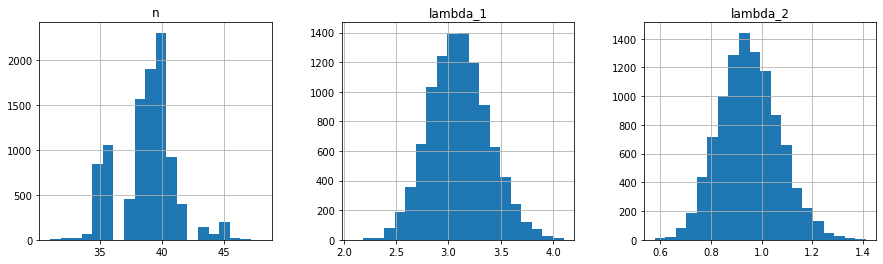

In [6]:
prior_params = {'a': 1.0, 'b': 1.0}  # Uniform prior for beta dist
sample_data = {'x': [float(x) for x in mine_df['Count'].values]}  # From sample dataset

params = {
    'lambda_1': Parameter(3.0, gamma, lambda a, b, x, n, **kwargs: {'shape':a + sum(x[:int(n)]), 'scale':1/(b+n)}),
    'lambda_2': Parameter(1.0, gamma, lambda a, b, x, n, **kwargs: {'shape':a + sum(x[int(n):]), 'scale':1/(b+len(x)-n)}),
    'n': Parameter(int(len(sample_data['x'])/2), sample_conditional_n),
}  # Reciprocal for scale as (b+n) corresponds to the rate of the process

gibbs = GibbsSampler(params = {**params, **prior_params, **sample_data})
output = gibbs.sampling_routine(10000)
output.hist(['n','lambda_1', 'lambda_2'], bins=20, figsize=(15, 4), layout=(1,3));  
# n is number of years since start of data (1851)

In [8]:
# 95% credible interval determined by quantiles from this data
u_quant = np.quantile(output['n'], 0.975)
l_quant = np.quantile(output['n'], 0.025)
median = np.quantile(output['n'], 0.5)

print(f"The median estimate obtained for n is {median}, with its 2.5% and 97.5% quantiles being {l_quant} and {u_quant} respectively.")

print(f"The posterior medians for the rates are roughly {np.quantile(output['lambda_1'], 0.5):.2f}, and {np.quantile(output['lambda_2'], 0.5):.2f} respectively.")

The median estimate obtained for n is 39.0, with its 2.5% and 97.5% quantiles being 35.0 and 44.0 respectively.
The posterior medians for the rates are roughly 3.09, and 0.95 respectively.


## Metropolis - Hastings

However, there are some problems where the conditional posterior is either unknown, or sufficinently complex that it cannot be practically sampled from.

In such cases, we must instead sample using a Metropolis-Hasting algorithm, introduced here. We may be able to combine this approach with the Gibbs approach, selecting the most applicable sampler for each variable.

First we will develop a framework for the Metropolis-Hastings algorithm, using another example from the aforementioned textbook.

### Problem 13.1 - Lyme Disease

Let us consider the the occurrence of Lyme disease in the UK, a
vector-borne disease caused by bacteria of the species Borrelia which is carried by ticks. We estimate the prevalence of these bacteria in ticks, based on a sample size of 100 ticks. 

We may use a binomial likelihood, under the assumption that the presence
of Borrelia in one tick is independent of that in other ticks. We may also assume that the presence of Borrelia is identically distributed across ticks, i.e. there is no heterogeneity across the sample region.

#### Priors

Specifying a $beta(1,1)$ distribution as a prior for the incidence $\theta$, we may use independent sampling to esti-
mate the prior predictive distribution to show that its mean is approximately 50.

$$
\theta_{i} \sim beta(1, 1); \; X_{i} \sim \mathcal{B}(100, \theta_{i})
$$

The mean incidence from the prior is 51.3102.


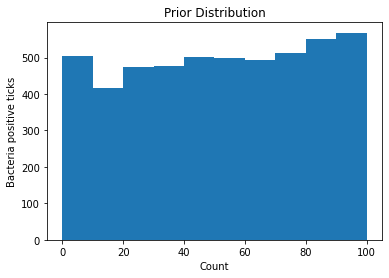

In [39]:
# Prior dist
a = 1; b = 1

def beta_binomial_sample(a, b, N, size):
    theta = np.random.beta(a=a, b=b, size=size)  # Uniform distribution
    return np.random.binomial(n=N, p=theta)

count = beta_binomial_sample(a, b, 100, 5000)
plt.hist(count); plt.xlabel('Count');
plt.ylabel('Bacteria positive ticks'); plt.title('Prior Distribution')
print(f"The mean incidence from the prior is {np.mean(count)}.")

In a single sample you find that there are 6 ticks that test positive for Borrelia.
For the same beta prior, we may graph the posterior distribution $(p(\theta | x) \propto p(x | \theta) p(\theta))$, and find its mean.

Fortunately the the beta prior here is conjugate to the binomial likelihood, giving a beta posterior of the form $beta(a+X, b+n−X)$, where $(a, b)$ are the prior parameters, $X$ is the number of ticks collected and $n$ is the sample size.

The mean incidence from the posterior (informed by the sample data) is 6.8874.


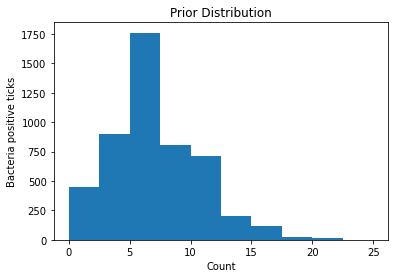

In [40]:
# Sample data:
N = 100; X = 6

count = beta_binomial_sample(a=(a+X), b=(b+N-X), N=N, size=5000)  # Uniform distribution
plt.hist(count); plt.xlabel('Count');
plt.ylabel('Bacteria positive ticks'); plt.title('Prior Distribution')
print(f"The mean incidence from the posterior (informed by the sample data) is {np.mean(count)}.")

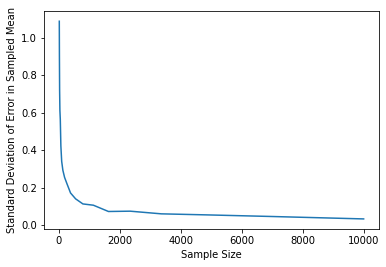

In [59]:
# Variance of posterior mean estimate with sample size

sizes = np.logspace(1, 4, 20)
errors = []
true_mean= 7/102
n_samples = 100

for size in sizes:
    means = []
    for _ in range(n_samples):
        count = beta_binomial_sample(a=(a+X), b=(b+N-X), N=N, size=int(size))
        means.append(np.mean(count))
    errors.append(np.std([np.abs(mean - true_mean) for mean in means]))
    
plt.plot(sizes, errors); plt.xlabel('Sample Size')
plt.ylabel('Standard Deviation of Error in Sampled Mean');

#### Metropolis-Hastings Sampling

We create a proposal function for this problem that takes as input a current value of $\theta$, along with a step size, and outputs a proposed value. For a proposal distribution here we use a normal distribution centred on the current $\theta$ value with a standard deviation (step size) of 0.1.

This requires generating a random $\theta$ from a normal distribution. However, to ensure that we don’t get $\theta < 0$ or $\theta > 1$ we use modular arithmetic to apply periodic boundary conditions. In particular we set $\theta_{proposed} = mod(\theta_{proposed}, 1)$.

Our update function also requires an accept/reject function in accordance with the Metropolis rule.

In [69]:
def proposal_func(theta, step_size):
    sample = np.random.normal(theta, step_size)
    return (sample % 1)

def posterior_estimate(theta):
    prior = ss.beta.pdf(x=theta, a=1, b=1)
    likelihood = ss.binom.pmf(k=X, n=N, p=theta)
    return prior * likelihood

def acceptance_decision(old_theta, new_theta):
    old_posterior = posterior_estimate(old_theta)
    new_posterior = posterior_estimate(new_theta)

    r = min(new_posterior / old_posterior, 1)
    decision = math.floor(r + np.random.random())
    return [old_theta, new_theta][decision]

def update_theta(old_theta):
    proposed_theta = proposal_func(old_theta, step_size=0.1)
    return acceptance_decision(old_theta, proposed_theta)

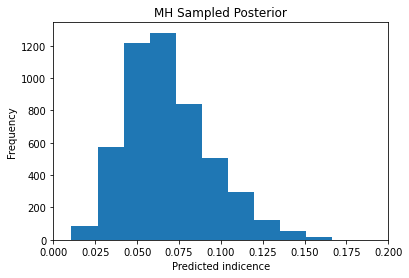

In [87]:
# Complete Metropolis-Hastings algorithm

def metropolis_alg(N_steps):
    theta = np.random.random()  # Initial value
    theta_values = [theta]
    for _ in range(N_steps):
        theta = update_theta(theta)
        theta_values.append(theta)
    return theta_values

output = metropolis_alg(N_steps=5000)
plt.hist(output, bins=10); plt.xlim(0, 0.2); plt.xlabel('Predicted indicence');
plt.ylabel('Frequency'); plt.title('MH Sampled Posterior');


It is worth noting this takes longer to converge than the independant sampler.

There is also a slight bias in the MCMC posterior towards the starting point of the algorithm. This is because sampler hasn’t had sufficient time to converge to the posterior. This bias can be removed by using more samples from the posterior and discarding those samples during the “warm-up” period.